# Observational setup

Here, we set up the observations of the eromapper cluster member galaxies at the AAT.

For each observation (which corresponds to one cluster), we need to produce a single `.fdl` file in the correct format.\
This file needs to include:

- The galaxies to observe (`members`) as the science targets (` = P`)
- The guide stars (` = F`)
- The sky fibres (` = S`),

Where the letter needs to provided with the sources.

## Preparation steps

For each of the clusters, the set up needs to follow the same procedure, which we can adapt from the files by Jacob:

- Select the members and calculate the central RA and DEC
- Select the White Dwarfs needed for spectral calibration [adopted from `SelectWDs1.py`]
- Generate the guide stars, initially taken from a region within 1 degree of centar RA and DEC [adopted from `Guidestargen1.py`].\
  These need to be filtered as well.
- Generate the sky fibres for the region [adopted from `skyfibrefromJacobfile3.py`]

### Adopted data structure

Until the last step, we just use dictionaries as our data structures, where the data structures listed in parentheses are mapped to the `cluster_id` (int) for each cluster:
- The `CLUSTER_INFO_DICT` (astropy table Row)
- The `CENTER_POSITION_DICT` (tuple(float, float))
- The `MEMBER_DICT` (astropy table)
- The `WHITE_DWARF_DICT` (astropy table)
- The `GUIDE_STAR_DICT` (astropy table)
- The `SKY_FIBRE_DICT` (astropy table)
  
## REQUIREMENTS:

For this script to work, the following packages need to be installed:
- `astropy`
- `astroquery`
- Standard modules like `numpy`, `scipy` (for the matching algorithm of astropy), and `matplotlib`

In [281]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
import astropy.units as u
from pathlib import Path
from astropy.coordinates import SkyCoord
import aat_clusters_scripts as acs


ALL_MEMBERS = Table.read(acs.PATHS.members)
CLUSTER_IDS = list(np.unique(ALL_MEMBERS["mem_match_id"]))
ALL_MEMBERS.add_index("mem_match_id")

ALL_CLUSTERS = Table.read(acs.PATHS.clusters)
ALL_CLUSTERS.add_index("mem_match_id")

# Set up the main data structure as explained above:
CLUSTER_INFO_DICT = {cluster_id: ALL_CLUSTERS.loc[cluster_id] for cluster_id in CLUSTER_IDS}
CENTRE_POSITION_DICT = {cluster_id: CLUSTER_INFO_DICT[cluster_id][["ra_corr", "dec_corr"]] for cluster_id in CLUSTER_IDS}

## Member selection

In this step, we select the cluster members to observe and format the table to have the columns we need.\
We also perform the following filtering:
- We discard all sources with $r\text{\_mag} < 17.5$ as they are too bright.

In [69]:
def add_information_to_member_table(member_table: Table) -> Table:
    """Retrieve the vital information for all members associated with this cluster id"""
    member_table["objid"] = [f"ero_member_{member['id']}" for member in member_table]
    hms_dms = np.array([hf.convert_radec_to_hmsdms(member["ra"], member["dec"], delimiter=" ", precision=2) for member in member_table])
    member_table["ra_hms"] = hms_dms[:, 0]
    member_table["dec_dms"] = hms_dms[:, 1]
    member_table["obs_type"] = "P"  # [P = 'Science targets', F = 'Guide stars', S = 'Sky fibres']
    member_table["priority"] = 9
    # The magnitudes are given as triplets in the [mag] column (as grz), so we select the middle one:
    member_table["mag_r"] = member_table["mag"][:, 1]
    # The program ID does not matter for us:
    member_table["program_id"] = 0
    # Since we're observing galaxies, their proper motions are 0:
    member_table["pm_ra"] = 0
    member_table["pm_dec"] = 0
    relevant_cols = ["objid", "ra_hms", "dec_dms", "obs_type", "priority", "mag_r", "program_id", "pm_ra", "pm_dec", "mem_match_id", "ra", "dec"]
    return member_table[relevant_cols]

CLEAN_MEMBERS = add_information_to_member_table(ALL_MEMBERS)
CLEAN_MEMBERS.add_index("mem_match_id")
CLEAN_MEMBERS[:3]

objid,ra_hms,dec_dms,obs_type,priority,mag_r,program_id,pm_ra,pm_dec,mem_match_id,ra,dec
str27,str14,str14,str1,int64,float32,int64,int64,int64,int32,float64,float64
ero_member_2076118471409708,12 03 13.0.47,-21 29 28.0.43,P,9,18.697887,0,0,0,-2060224498,180.80611594001587,-21.4912293589975
ero_member_2082921699607324,12 03 21.0.68,-21 38 09.0.56,P,9,18.386673,0,0,0,-2060224498,180.84033329340832,-21.635989167716435
ero_member_2082921699609675,12 03 45.0.35,-21 39 58.0.72,P,9,19.626753,0,0,0,-2060224498,180.93895607843925,-21.666310433307263


## White Dwarf selection

We want to observe some White Dwarfs to calibrate our spectra.

The White Dwarf catalogue has been obtained from the Gaia EDR3 ([download link](https://warwick.ac.uk/fac/sci/physics/research/astro/research/catalogues/gaiaedr3_wd_main.fits.gz)), described Gentile Fusillo et al. 2021 (see [here](https://arxiv.org/pdf/2106.07669.pdf) for the pdf).

For the selection, we follow the procedure adopted in `SelectWD1.py` with an additional restriction:
- We select all white dwarfs within a radius of `1 deg` of the central ra and dec for each cluster.
- Also, we require `RPmag`, `pmra` und `pmdec` to exist (although this seems to be ok for all sources).

In [240]:


WHITE_DWARF_DICT = {}
for cluster_id in CLUSTER_IDS:
    ra, dec = CENTRE_POSITION_DICT[cluster_id]
    wd_selection = hf.get_objects_in_circular_region(ALL_WHITE_DWARFS, ra, dec)
    print(f"{cluster_id}:\t{len(wd_selection)} white dwarfs in region")
    relevant_cols = ["WDJ_name", "source_id", "ra", "dec", "RPmag", "pmra", "pmdec"]
    wd_selection = wd_selection[relevant_cols]
    wd_selection = hf.filter_for_existing_cols(wd_selection)
    print(f"{cluster_id}:\t{len(wd_selection)} white dwarfs with available rmag and proper motion data")

    WHITE_DWARF_DICT[cluster_id] = wd_selection
    print(
np.sum(wd_selection["RPmag"] < 17.5))
# COMMENT: We seem to be lacking WDs with rmag data for the first two clusters!
# CORRECTION to comment: Apparently we need to use RPmag and not rmag!
# NOTE: Ask mara about the difference!

-2060224498:	30 white dwarfs in region
-2060224498:	30 white dwarfs with available rmag and proper motion data
0
-1855905442:	28 white dwarfs in region
-1855905442:	28 white dwarfs with available rmag and proper motion data
2
-879663103:	24 white dwarfs in region
-879663103:	24 white dwarfs with available rmag and proper motion data
0


## Select the guide stars


We follow the procedure in `Guidestargen1.py`:

- First, we obtain objects in range of the cluster from SIMBAD.
- Then, all guide stars without `pmra`, `pmdec` or `rmag` values are removed.
- All sources too dim, too bright, or with a high proper motion are removed, corresponding to the following criteria:
  - $12 < r \text{\_mag} < 14$
  - $pm < 20$, where $pm:=\sqrt{(0.3977 pm_\text{ra})^2+pm_\text{dec}^2}$
- Then, it is made sure that the type of the sources is stellar.
- Finally, the sources are sorted by their r magnitude.

In [261]:
GUIDE_R_MAX = 14
GUIDE_R_MIN = 12
GUIDE_PM_MAX = 20  # ! Jacob has differed his values here, talk with Mara

### Query the Simbad database

The following code could also manually be done by performing a coordinate query [on the Simbad site](http://simbad.cds.unistra.fr/simbad/sim-fcoo), but the use of astroquery seems to be more convenient (I have briefly tested it, it yields the same results).\
We adopt a search radius of `1 degree` around the centre of each observation.

In [263]:
from astroquery.simbad import Simbad

def _sanitize_simbad_table(table: Table) -> Table:
    # Sanitize the table by lowercasing colnames and turning ra and dec to degrees
    table.rename_columns(cols := table.colnames, [col.lower() for col in cols])
    sky_coords = SkyCoord(simbad_sources["ra"], simbad_sources["dec"], unit=(u.hourangle, u.deg))
    table["ra"] = sky_coords.ra
    table["dec"] = sky_coords.dec
    table.rename_column("flux_r", "rmag")
    return table


def retrieve_simbad_table(ra: float, dec: float, radius: float = 1) -> Table:
    """Retrieve the simbad sources around the given central `ra` and `dec` within
    the provided `radius` (in deg)."""
    custom_simbad = Simbad()
    print(custom_simbad.get_votable_fields())
    custom_simbad.add_votable_fields("fluxdata(R)", "pmra", "pmdec")
    sources = custom_simbad.query_region(SkyCoord(ra, dec, unit="deg"), radius=radius*u.deg)
    return _sanitize_simbad_table(sources)

def calc_pm_tot(pmra: float, pmdec: float) -> float:
    """Calculate the total proper motion of a given source according to Jacob's formula"""
    return np.sqrt((0.3977 * pmra)**2 + pmdec**2)
    

ra, dec = CENTRE_POSITION_DICT[CLUSTER_IDS[1]][0], CENTRE_POSITION_DICT[CLUSTER_IDS[1]][1]
# simbad_sources = retrieve_simbad_table(ra, dec)
with_flux = hf.filter_for_existing_cols(simbad_sources, ("rmag", "pmra", "pmdec"))
with_flux["pm_tot"] = calc_pm_tot(with_flux["pmra"], with_flux["pmdec"])
mask = with_flux["rmag"] <= GUIDE_R_MAX
mask &= with_flux["rmag"] >= GUIDE_R_MIN
mask &= with_flux["pm_tot"] <= GUIDE_PM_MAX
print(f"{len(simbad_sources) = }\n{len(with_flux) = }\n{len(with_flux[mask]) = }")

len(simbad_sources) = 600
len(with_flux) = 282
len(with_flux[mask]) = 193


## Select the sky fibres

The 

Text(0.5, 1.0, 'Sky fibres in relation to the clusters')

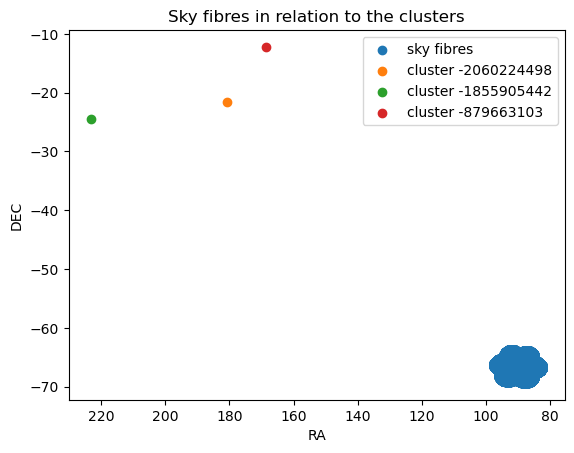

In [278]:

def _sanitize_fibre_table(table: Table) -> Table:
    # Sanitize the table by lowercasing colnames and turning ra and dec to degrees
    table.rename_columns(cols := table.colnames, [col.lower() for col in cols])
    sky_coords = SkyCoord(table["ra"], table["dec"], unit="deg")
    table["ra"] = sky_coords.ra
    table["dec"] = sky_coords.dec
    return table


ALL_FIBRES = _sanitize_fibre_table(PATHS.read_table(PATHS.sky_fibres))
hf.get_objects_in_circular_region(ALL_FIBRES, ra, dec)
fig, ax = plt.subplots()
ax.scatter(ALL_FIBRES["ra"], ALL_FIBRES["dec"], label="sky fibres")
for cluster_id in CLUSTER_IDS:
    ra, dec = CENTRE_POSITION_DICT[cluster_id]
    ax.scatter(ra, dec, label=f"cluster {cluster_id}")
ax.set_xlabel("RA")
ax.set_ylabel("DEC")
ax.invert_xaxis()
ax.legend()
ax.set_title("Sky fibres in relation to the clusters")

In [3]:
# Copied file header:
LABEL = "eromapper cluster follow-up"
UTDATE = "2023 02 19"
CENTRE = "CENTER_STRING"
FILE_HEADER = f"""
LABEL {LABEL}
UTDATE {UTDATE}
CENTRE {CENTRE}
EQUINOX J2000
WLEN1 6000
PROPER_MOTIONS
"""

In [4]:
COMMENT = """
#                       R. Ascention    Declination             Prog    Proper Motion           Comments
# Name                  hh  mm ss.sss   dd  mm ss.sss                   mag     ID      ra              dec 
# """

In [5]:

fname = Path("./data/observation_setup/target_selection.fdl")
ALL_MEMBERS[relevant_cols].write(fname, format="ascii", overwrite=True)